# 2021년 2학기 빅데이터분석 중간고사

- toc:flase
- branch: master
- badges: flase
- comments: flase 
- author: 최규빈

## 통계학과 201618968 김종원

- 환경 : colab

## 1번

### (a) 두가지 키워드로 크롤링하여 이미지 자료를 모으고 CNN 모형을 활용하여 분석하라.

#### Import

In [1]:
!pip install --upgrade fastai
from fastai.data.all import *
from fastai.vision.all import *
import os

     |████████████████████████████████| 189 kB 8.6 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


#### Crawling

In [ ]:
def search_images_ddg(key,max_n=200):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
       (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass


In [ ]:
keywords = 'tiger' , 'lion'
path=Path('animals')

In [ ]:
if not path.exists():
  path.mkdir()
  for keyword in keywords:
    lastpath=path/keyword
    lastpath.mkdir(exist_ok=True)
    urls=search_images_ddg(keyword)
    download_images(lastpath,urls=urls)

#### Cleaning Data

In [ ]:
delimg = verify_images(get_image_files(path))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


In [ ]:
for i in range(len(delimg)):
  os.remove(delimg[i])

#### Data

In [ ]:
dls = ImageDataLoaders.from_folder(
    path,
    train='animals',
    valid_pct=0.2,
    item_tfms=Resize(224)
)

#### Learn

In [ ]:
lrnr = cnn_learner(dls, resnet34, metrics=error_rate)
lrnr.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.874940,0.026567,0.000000,01:57


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.155063,0.010001,0.000000,02:39
1,0.109933,0.002694,0.000000,02:38
2,0.078140,0.000949,0.000000,02:38


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


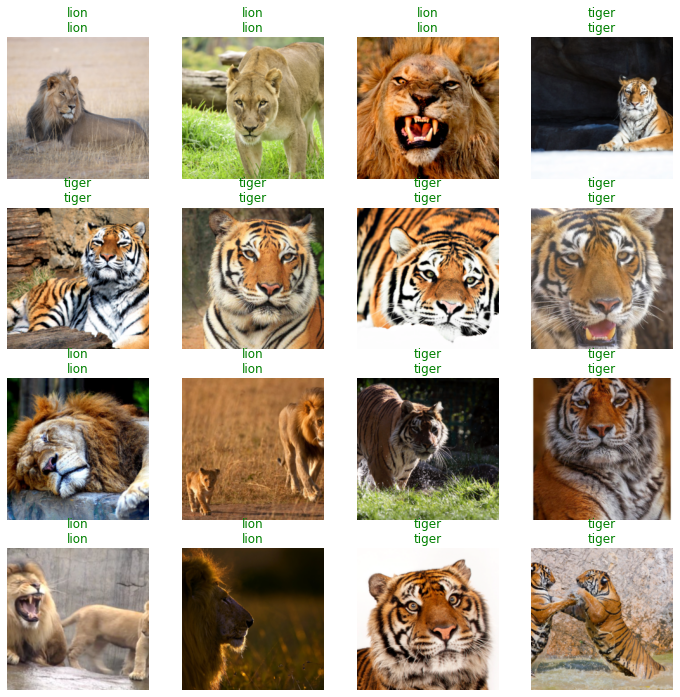

In [ ]:
lrnr.show_results(max_n=16)

`-` 오답 분석

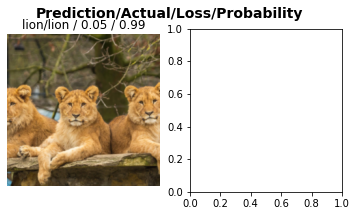

In [ ]:
interp = Interpretation.from_learner(lrnr)
interp.plot_top_losses(2)

- 오답이라고 부를만한 샘플이 1개 밖에 없을 정도로 잘 학습되었습니다.

### (b) CAM을 이용하여 CNN의 판단근거를 시각화하라.

#### CAM

In [ ]:
net1 = lrnr.model[0]
net2 = lrnr.model[1]

In [ ]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(512, out_features=2, bias=False))

In [ ]:
net = torch.nn.Sequential(net1, net2)
lrnr2 = Learner(dls, net, metrics=accuracy)

In [ ]:
lrnr2.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.372894,0.647963,0.824324,02:37


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,accuracy,time
0,0.329177,0.010415,1.000000,02:38
1,0.208410,0.521518,0.878378,02:38
2,0.160110,0.738622,0.824324,02:38


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


#### Visualization

In [ ]:
dls.vocab

['lion', 'tiger']

- 뒤의 값이 클수록 호랑이라고 판단합니다.

`-` 사자 학습 결과

In [ ]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        lionprob, tigerprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if lionprob>tigerprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("lion(%s)" % lionprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("tiger(%s)" % tigerprob.round(5))
        k=k+1 
fig.set_figwidth(16)
fig.set_figheight(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

`-` 호랑이 학습 결과

In [ ]:
fig, ax = plt.subplots(5,5) 
k=200 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        lionprob, tigerprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if lionprob>tigerprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("lion(%s)" % lionprob.round(5))
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,223,223,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("tiger(%s)" % tigerprob.round(5))
        k=k+1 
fig.set_figwidth(16)
fig.set_figheight(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

- 암수 구별없이 특징이 뚜렷한 호랑이와 달리 암컷과 수컷, 새끼의 모습이 다른 사자는 제대로 학습되지 않으며 중요한 부분을 제대로 못 찾는 것으로 보입니다.

## 2번

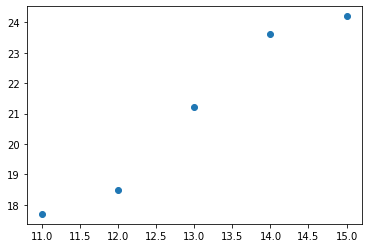

In [ ]:
x = torch.tensor((11, 12, 13, 14, 15))
y = torch.tensor((17.7, 18.5, 21.2, 23.6, 24.2))
n = len(x)
ones = torch.ones(n)
X = torch.vstack([ones, x]).T

plt.plot(x,y,'o')

### (a) 네트워크 설계, 손실함수( MSELoss ) 정의, $ ( \beta_0, \beta_1 ) = (3,3) $ 일 때, loss 계산

In [ ]:
net = torch.nn.Linear(in_features=2, out_features=1, bias=False)

In [ ]:
lossfn = torch.nn.MSELoss()

In [ ]:
net.weight.data = torch.tensor( [[3.0, 3.0]] )
yhat = net(X)
loss = lossfn(y.reshape(n, 1), yhat)
print( 'Loss = ' , loss.data )

Loss =  tensor(442.4360)


### (b) $ ( \beta_0, \beta_1 ) = (3,3) $**굵은 텍스트** 에서 손실함수의 미분계수 계산

In [ ]:
loss.backward()
net.weight.data

tensor([[3., 3.]])

### (c) 경사하강법을 통해 $ ( \beta_0, \beta_1 ) = (3,3) $ 의 값을 학습률 0.01로 1회 update

In [ ]:
optmz = torch.optim.SGD(net.parameters(), lr=0.01)
optmz.step()

In [ ]:
net.weight.data

tensor([[ 2.5808, -2.4972]])

## 3번

### Data

In [ ]:
import pandas as pd 
df=pd.read_csv('https://raw.githubusercontent.com/guebin/2021BDA/master/_notebooks/2021-11-06-prob3.csv')
df.head()

,x,y
0,0.0,4.962202
1,0.1,4.889815
2,0.2,4.605782
3,0.3,4.491711
4,0.4,4.344537


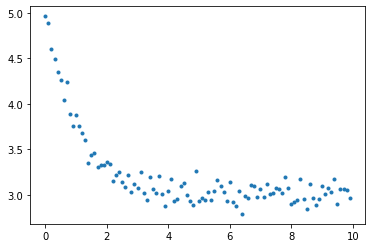

In [ ]:
plt.plot(df.x, df.y, '.')

In [ ]:
x = torch.tensor(df.x, dtype=torch.float32)
ex = torch.exp(-x)
y = torch.tensor(df.y, dtype=torch.float32)
n = len(x)
ones = torch.ones(n)
X = torch.vstack([ones, ex]).T

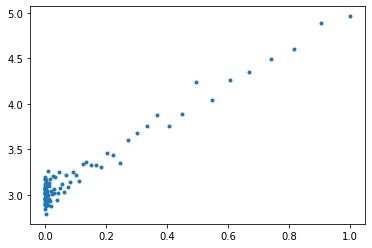

In [ ]:
plt.plot(ex, y, '.')

### Learn

In [ ]:
epoc = 100

#### $ \alpha = 0.01 $

In [ ]:
alpha = 0.01

net1 = torch.nn.Linear(in_features=2, out_features=1, bias=False)
mseloss1 = torch.nn.MSELoss()
losses1 = 0

optmz1 = torch.optim.SGD(net1.parameters(), lr=alpha)
for i in range(epoc):
  yhat1 = net1(X)
  loss1 = mseloss1(y.reshape(n, 1), yhat1)
  losses1 = loss1.item()
  loss1.backward()
  optmz1.step()
  optmz1.zero_grad()

In [ ]:
losses1

0.2879681885242462

#### $ \alpha = 0.05 $

In [ ]:
alpha = 0.05

net2 = torch.nn.Linear(in_features=2, out_features=1, bias=False)
mseloss2 = torch.nn.MSELoss()
losses2 = 0

optmz2 = torch.optim.SGD(net2.parameters(), lr=alpha)
for i in range(epoc):
  yhat2 = net2(X)
  loss2 = mseloss2(y.reshape(n, 1), yhat2)
  losses2 = loss2.item()
  loss2.backward()
  optmz2.step()
  optmz2.zero_grad()

In [ ]:
losses2

0.09019309282302856

#### $ \alpha = 0.1 $

In [ ]:
alpha = 0.1

net3 = torch.nn.Linear(in_features=2, out_features=1, bias=False)
mseloss3 = torch.nn.MSELoss()
losses3 = 0

optmz3 = torch.optim.SGD(net3.parameters(), lr=alpha)
for i in range(epoc):
  yhat3 = net3(X)
  loss3 = mseloss3(y.reshape(n, 1), yhat3)
  losses3 = loss3.item()
  loss3.backward()
  optmz3.step()
  optmz3.zero_grad()

In [ ]:
losses3

0.02633320726454258

- $ \alpha = 0.1 $ 일 때 loss가 가장 낮으므로 해당 가중치를 적절한 $ \beta $ 로 결정합니다.

In [ ]:
net3.weight.data

tensor([[3.0803, 1.3901]])

- 따라서 $ ( \beta_0, \beta_1 ) = (3.08, 1.39) $ 입니다.

## 4번

`(1)` 경사하강법은 손실함수와 상관없이 언제나 전역최소해를 찾을 수 있다. 

- X

`(2)` 확률적경사하강법은 손실함수와 상관없이 언제 전역최소해를 찾을 수 있다. 

- X

`(3)` 일반근사정리(universal approximation theorem)는 충분히 깊은 신경망이 어떠한 함수든 표현할 수 있다는 내용의 이론이다. 

- X

`(4)` $y_i=\beta_0+\beta_1 x_i+\epsilon_i$ 와 같은 형태의 단순회귀모형은 학습해야할 파라메터가 2개이다. 

- O

`(5)` 참모형(true model)이 단순회귀모형일 경우, 비선형 활성화 함수를 사용한 깊은신경망으로 모형을 적합시키면 오히려 적합력이 떨어진다. 

- X

`(6)` 확률적 경사하강법은 관측자료에 임의의 오차항을 더하여 학습시키는 방법이다. 

- X

`(7)` 경사하강법은 손실함수가 convex일 경우 언제나 전역최소해를 찾을 수 있다. 

- O

`(8)` 로지스틱 모형에서 MSEloss를 사용하더라도 전역최소해를 찾는 경우가 있다. 즉 시그모이드 활성화 함수와 MSEloss를 사용한다고 하여도 항상 전역최소해를 찾지 못하는 것은 아니다. 

- O

`(9)` 로지스틱 모형에서 MLELoss를 사용하면 옵티마이저를 Adam으로 선택하고 BCELoss를 사용하면 확률적 경사하강법을 사용한다. 

- X

`(10)` 확률적 경사하강법은 컴퓨터의 자원을 효율적으로 활용할 수 있도록 도와준다. 

- O

`(11)` 학습할 파라메터가 많을수록 GPU의 학습속도가 CPU의 학습속도 보다 빠르다. 

- O

`(12)` GPU는 언제나 CPU보다 빠르게 모형을 학습한다. 

- X

`(13)` CNN 모형에서 에서 2D콘볼루션은 비선형 변환이다. 

- X

`(14)` 드랍아웃은 결측치를 제거하는 기법이다. 

- X

`(15)` 모든 관측치를 활용하지 않고 일부의 관측치만 활용하여 학습하는 기법을 드랍아웃이라 한다. 

- X

`(16)` 확률적 경사하강법은 드랍아웃과 같이 사용할 수 없다. 

- X

`(17)` MLP의 모든 활성화 함수가 선형이라면 은닉층(Hidden Layer)을 아무리 추가하여도 모형의 표현력이 향상되지 않는다. 

- O

`(18)` 학습할 파라메터수가 증가하면 언더피팅의 위험이 있다. 

- X

`(19)` CAM은 CNN의 모든층에서 사용가능하다. 

- X

`(20)` CAM은 CNN모형의 일부를 수정해야 한다는 점에서 단점이 있다. 

- O

`(21)` CNN은 이미지 자료만 분석할 수 있다. 

- X

`(22)` 드랍아웃은 과적합을 방지하는 효과가 있다. 

- O

`(23)` 예측 및 적합을 할때는 네트워크에서 드랍아웃층을 제거해야 한다. 

- O

`(24)` BCELoss는 Softmax 활성화 함수와 잘 어울린다. 

- X

`(25)` 파이토치에서 미분을 수행하는 메소드는 backward() 이다. 

- O